In [1]:
#import Panda and Numpy and other libraries for use
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
#to view our charts inline, not a separate window

from sklearn.linear_model import LogisticRegression #as LogReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import tree 
#for our secondary regression test, seeing if 
#tree or LogReg give vastly different results

In [2]:
#defining the location for data and attempting to read it with panda
location = "datasets/DC_Properties.csv"
dc_df = pd.read_csv(location, low_memory=False)
dc_df.head()

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,0152,-77.040429,38.914881,NW


## Initial Exploration

In [3]:
dc_df.shape

(158957, 49)

In [4]:
dc_df.columns

Index(['Unnamed: 0', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'PRICE',
       'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE',
       'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES',
       'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'CMPLX_NUM',
       'LIVING_GBA', 'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID',
       'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD',
       'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT'],
      dtype='object')

In [5]:
#creating a data frame with price-relevant data 
#(bedrooms as proxy for house size)


test_df = pd.DataFrame(data=dc_df, columns=['BEDRM','PRICE','ZIPCODE','USECODE','WARD','YR_RMDL','CNDTN'])

test_df.head()



,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
0,4,1095000.0,20009.0,24,Ward 2,1988.0,Good
1,5,NaN,20009.0,24,Ward 2,2007.0,Good
2,5,2100000.0,20009.0,24,Ward 2,2009.0,Very Good
3,5,1602000.0,20009.0,24,Ward 2,2003.0,Good
4,3,NaN,20009.0,13,Ward 2,2012.0,Good


In [6]:
#looking for empty values, I will be replacing them
test_df.isnull().sum()

BEDRM          0
PRICE      60741
ZIPCODE        1
USECODE        0
WARD           1
YR_RMDL    78029
CNDTN      52261
dtype: int64

In [7]:
#sorting ward by median price
test_df['PRICE'].groupby(test_df['WARD']).mean()

WARD
Ward 1    5.738363e+05
Ward 2    1.098570e+06
Ward 3    3.077716e+06
Ward 4    4.899224e+05
Ward 5    3.952432e+05
Ward 6    5.268684e+05
Ward 7    2.339222e+05
Ward 8    2.715224e+05
Name: PRICE, dtype: float64

In [8]:
miss_price = test_df.loc[test_df['PRICE'].isnull()]
miss_price.head()

,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
1,5,NaN,20009.0,24,Ward 2,2007.0,Good
4,3,NaN,20009.0,13,Ward 2,2012.0,Good
6,2,NaN,20009.0,24,Ward 2,1988.0,Average
9,2,NaN,20009.0,11,Ward 2,1979.0,Average
10,5,NaN,20009.0,24,Ward 2,1950.0,Fair


In [9]:
mispr = list(miss_price.index)

In [10]:
#making a list with replaced --mean--missing PRICE
test_df['PRICE'].fillna(test_df.groupby(['WARD'])['PRICE'].transform('mean'), inplace=True)
test_df.iloc[mispr].head()       
#iloc to see if our replacement worked...and it DOES!!!

,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
1,5,1.098570e+06,20009.0,24,Ward 2,2007.0,Good
4,3,1.098570e+06,20009.0,13,Ward 2,2012.0,Good
6,2,1.098570e+06,20009.0,24,Ward 2,1988.0,Average
9,2,1.098570e+06,20009.0,11,Ward 2,1979.0,Average
10,5,1.098570e+06,20009.0,24,Ward 2,1950.0,Fair


In [11]:
test_df.isnull().sum()
#one price is still NaN...maybe we can remove that one!

BEDRM          0
PRICE          1
ZIPCODE        1
USECODE        0
WARD           1
YR_RMDL    78029
CNDTN      52261
dtype: int64

In [12]:
stillgone = test_df.loc[test_df['PRICE'].isnull()]
stillgone.head()

,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
104610,4,NaN,NaN,23,NaN,NaN,Average


In [13]:
#convoluted method to get rid of stillgone! What an annoying row.
test_df = test_df[np.isfinite(test_df['PRICE'])]

In [14]:
test_df.isnull().sum()

BEDRM          0
PRICE          0
ZIPCODE        0
USECODE        0
WARD           0
YR_RMDL    78028
CNDTN      52261
dtype: int64

In [15]:
test_df.head()

,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
0,4,1.095000e+06,20009.0,24,Ward 2,1988.0,Good
1,5,1.098570e+06,20009.0,24,Ward 2,2007.0,Good
2,5,2.100000e+06,20009.0,24,Ward 2,2009.0,Very Good
3,5,1.602000e+06,20009.0,24,Ward 2,2003.0,Good
4,3,1.098570e+06,20009.0,13,Ward 2,2012.0,Good


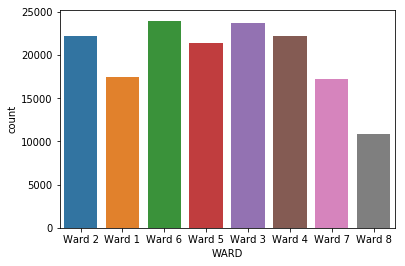

In [16]:
#how many homes from which wards are present in the data
#Ward 8 is the lowest, Ward 6 and 3 (the largest)
sns.countplot(x='WARD',data=dc_df)

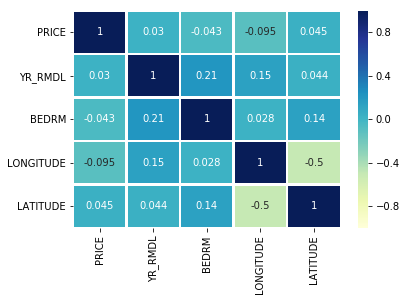

In [17]:
#trying to make a new dataframe to look at WARD and PRICE more rigorously
#here we go:

wardpr = dc_df[['WARD','PRICE','YR_RMDL','BEDRM','LONGITUDE','LATITUDE']]

warheat = wardpr.corr()

sns.heatmap(warheat, vmin=-1, annot=True, linewidths=1.5, cmap="YlGnBu")

# Predicting Price

<i>So, the data I tried running my regression on wasn't very successful. I may try to play around with it tonight (Thursday), but that depends on how my packing to move comes along (eep).
</i>
<p>It would appear that LogReg is not happy running a regression on PRICE that is not grouped into either a binary or into bins.
I would have to fit the data into bins, and that takes more time finding stuff to do that...oof.
</p>

In [18]:
#just trying to remember what we are looking at! Less scrolling
test_df.head()

,BEDRM,PRICE,ZIPCODE,USECODE,WARD,YR_RMDL,CNDTN
0,4,1.095000e+06,20009.0,24,Ward 2,1988.0,Good
1,5,1.098570e+06,20009.0,24,Ward 2,2007.0,Good
2,5,2.100000e+06,20009.0,24,Ward 2,2009.0,Very Good
3,5,1.602000e+06,20009.0,24,Ward 2,2003.0,Good
4,3,1.098570e+06,20009.0,13,Ward 2,2012.0,Good


In [19]:
#using dummies to 'numericalize' WARD and CNDTN data
#this will allow our machine algorithm to make use of
#the qualitative data in CNDTN and the geographical
#data in WARD
primo = pd.get_dummies(data=test_df, columns=['WARD','CNDTN'])
primo.head()

,BEDRM,PRICE,ZIPCODE,USECODE,YR_RMDL,WARD_Ward 1,WARD_Ward 2,WARD_Ward 3,WARD_Ward 4,WARD_Ward 5,WARD_Ward 6,WARD_Ward 7,WARD_Ward 8,CNDTN_Average,CNDTN_Default,CNDTN_Excellent,CNDTN_Fair,CNDTN_Good,CNDTN_Poor,CNDTN_Very Good
0,4,1.095000e+06,20009.0,24,1988.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,5,1.098570e+06,20009.0,24,2007.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,5,2.100000e+06,20009.0,24,2009.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5,1.602000e+06,20009.0,24,2003.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,3,1.098570e+06,20009.0,13,2012.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
#following steps from Module 8 to attempt Logistic Regression
primo.shape

(158956, 20)

In [25]:
#extracting target value
#copying the target value column
y = primo['PRICE']

In [26]:
#copy of PRIMO without the 'PRICE' column
X = primo.drop(['PRICE','ZIPCODE','USECODE','YR_RMDL'], axis = 1)

In [29]:
#setting up the training...let's start with 75% training, 25% test
#and hope this works
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=32)
